In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

from datetime import datetime

In [2]:
lr=1e-5
batch_size = 64
n_epochs = 10

In [3]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
train_dataset = torchvision.datasets.ImageFolder(
    root='../data/chest_xray/chest_xray/train/',
    transform=data_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    root='../data/chest_xray/chest_xray/test/',
    transform=data_transforms
)

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device.upper()} is used')

Device: CUDA:0 is used


In [6]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
)

In [7]:
class VGG_body(nn.Module):
    def __init__(self, vgg):
        super(VGG_body, self).__init__()
        self.features = vgg.features
        self.avgpool = vgg.avgpool
    
    def forward(self, inputs):
        outputs = self.features(inputs)
        outputs = self.avgpool(outputs)
        outputs = outputs.view(inputs.size(0), -1)
        
        return outputs

In [8]:
vgg = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)

n_features = vgg.classifier[0].in_features

vggFeatures = VGG_body(vgg)

vggFeatures.to(device)

VGG_body(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [9]:
n_train = len(train_dataset)
n_test = len(test_dataset)
n_train, n_test

(5216, 624)

In [10]:
train_inputs_precalculated = np.zeros((n_train, n_features))
test_inputs_precalculated = np.zeros((n_test, n_features))
train_targets = np.zeros((n_train, 1))
test_targets = np.zeros((n_test, 1))

In [11]:
with torch.no_grad():

    i = 0
    for inputs, targets in train_dataloader:
        inputs = inputs.to(device)
        outputs = vggFeatures(inputs)

        size = len(outputs)

        train_inputs_precalculated[i : i + size] = outputs.cpu().numpy()
        train_targets[i : i + size] = targets.view(-1, 1).numpy()

        i += size
        
        print(f'Precalculated {i}/{n_train} train samples')
        
    print('Train dataset precalculated')

Precalculated 64/5216 train samples
Precalculated 128/5216 train samples
Precalculated 192/5216 train samples
Precalculated 256/5216 train samples
Precalculated 320/5216 train samples
Precalculated 384/5216 train samples
Precalculated 448/5216 train samples
Precalculated 512/5216 train samples
Precalculated 576/5216 train samples
Precalculated 640/5216 train samples
Precalculated 704/5216 train samples
Precalculated 768/5216 train samples
Precalculated 832/5216 train samples
Precalculated 896/5216 train samples
Precalculated 960/5216 train samples
Precalculated 1024/5216 train samples
Precalculated 1088/5216 train samples
Precalculated 1152/5216 train samples
Precalculated 1216/5216 train samples
Precalculated 1280/5216 train samples
Precalculated 1344/5216 train samples
Precalculated 1408/5216 train samples
Precalculated 1472/5216 train samples
Precalculated 1536/5216 train samples
Precalculated 1600/5216 train samples
Precalculated 1664/5216 train samples
Precalculated 1728/5216 trai

In [12]:
with torch.no_grad():
    i = 0
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)
        outputs = vggFeatures(inputs)

        size = len(outputs)

        test_inputs_precalculated[i : i + size] = outputs.cpu().numpy()
        test_targets[i : i + size] = targets.view(-1, 1).numpy()
        
        i += size
        
        print(f'Precalculated {i}/{n_test} test samples')
        
    print('Test dataset precalculated')


Precalculated 64/624 test samples
Precalculated 128/624 test samples
Precalculated 192/624 test samples
Precalculated 256/624 test samples
Precalculated 320/624 test samples
Precalculated 384/624 test samples
Precalculated 448/624 test samples
Precalculated 512/624 test samples
Precalculated 576/624 test samples
Precalculated 624/624 test samples
Test dataset precalculated


In [20]:
train_inputs_precalculated = torch.from_numpy(train_inputs_precalculated)
test_inputs_precalculated = torch.from_numpy(test_inputs_precalculated)
train_targets = torch.from_numpy(train_targets)
test_targets = torch.from_numpy(test_targets)

AttributeError: 'Tensor' object has no attribute 'astype'

In [ ]:
train_dataset = TensorDataset(train_inputs_precalculated, train_targets)
test_dataset = TensorDataset(test_inputs_precalculated, test_targets)

In [28]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
)

In [42]:
model = nn.Sequential(
    nn.Linear(n_features, 128),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)
model.to(device)

Sequential(
  (0): Linear(in_features=25088, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=1, bias=True)
  (2): Sigmoid()
)

In [43]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

In [44]:
def validate(dataset, batch_size=128):
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
    )

    tot_predicted = 0
    tot_correct = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

        inputs = inputs.to(torch.float)
        targets = targets.to(torch.float)
        
        tot_predicted += inputs.shape[0]
        outputs = model(inputs)

        predictions = torch.round(outputs)

        tot_correct += (predictions == targets).sum()

    return (tot_correct/tot_predicted)

In [45]:
def train(n_epochs=100):
    
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    train_accuracies = np.zeros(n_epochs)
    test_accuracies = np.zeros(n_epochs)

    for it in range(n_epochs):
        
        start_time = datetime.now()

        train_loss = []
        test_loss = []

        for i, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            optimizer.zero_grad()
            
            inputs = inputs.to(torch.float)
            targets = targets.to(torch.float)

            outputs = model(inputs)
            
            loss = criterion(outputs, targets.to(torch.float32))
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        train_losses[it] = np.mean(train_loss)

        for i, (inputs, targets) in enumerate(test_dataloader):
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            
            inputs = inputs.to(torch.float)
            targets = targets.to(torch.float)

            outputs = model(inputs)
            loss = criterion(outputs, targets.to(torch.float32))
            test_loss.append(loss.item())

        test_losses[it] = np.mean(test_loss)

        train_accuracies[it] = validate(train_dataset, batch_size=batch_size)
        test_accuracies[it] = validate(test_dataset, batch_size=batch_size)

        duration = datetime.now()-start_time
        
        print(
            f"Iteration: {it+1:2}/{n_epochs}\tTrain Loss: {train_losses[it]:.6f}\tTest Loss: {test_losses[it]:.6f}\tTrain Accuracy: {train_accuracies[it]:.2f}\tTest Accuracy: {test_accuracies[it]:.2f}\tDuration: {duration}"
        )

    return train_losses, test_losses, train_accuracies, test_accuracies


In [46]:
train_losses, test_losses, train_accuracies, test_accuracies = train(n_epochs=100)


Iteration:  1/100	Train Loss: 0.702212	Test Loss: 0.673906	Train Accuracy: 0.60	Test Accuracy: 0.58	Duration: 0:00:02.026386
Iteration:  2/100	Train Loss: 0.653492	Test Loss: 0.653354	Train Accuracy: 0.73	Test Accuracy: 0.62	Duration: 0:00:02.081060
Iteration:  3/100	Train Loss: 0.615965	Test Loss: 0.638925	Train Accuracy: 0.75	Test Accuracy: 0.63	Duration: 0:00:01.892352
Iteration:  4/100	Train Loss: 0.586497	Test Loss: 0.627628	Train Accuracy: 0.75	Test Accuracy: 0.63	Duration: 0:00:01.727143
Iteration:  5/100	Train Loss: 0.561226	Test Loss: 0.617875	Train Accuracy: 0.75	Test Accuracy: 0.63	Duration: 0:00:01.717999
Iteration:  6/100	Train Loss: 0.539332	Test Loss: 0.608536	Train Accuracy: 0.76	Test Accuracy: 0.63	Duration: 0:00:01.750477
Iteration:  7/100	Train Loss: 0.518152	Test Loss: 0.599642	Train Accuracy: 0.76	Test Accuracy: 0.63	Duration: 0:00:01.747812
Iteration:  8/100	Train Loss: 0.499413	Test Loss: 0.591112	Train Accuracy: 0.77	Test Accuracy: 0.64	Duration: 0:00:01.795152


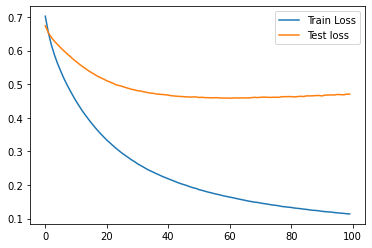

In [47]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test loss')
plt.legend()

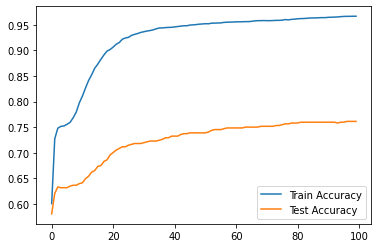

In [48]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()